In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First Attempt. Was not successful. Information loss and error values were MASSIVE. Decided to come back later, if time provided.

Did come back later, resized images to 256x256. Loss still remained massive, so was not able to optimize.

In [ ]:

import torch
from torch import nn
import torch.nn.functional as F

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=5000, z_dim=500):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma

In [ ]:

import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader


In [ ]:

import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class RawReferenceDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # List to store tuples of (raw_img_path, reference_img_path, original_size)

        raw_dir = os.path.join(root_dir, 'Raw')
        reference_dir = os.path.join(root_dir, 'Reference')

        raw_images = sorted(os.listdir(raw_dir))
        reference_images = sorted(os.listdir(reference_dir))

        for raw_img, ref_img in zip(raw_images, reference_images):
            raw_img_path = os.path.join(raw_dir, raw_img)
            ref_img_path = os.path.join(reference_dir, ref_img)


            original_image = Image.open(raw_img_path)
            original_size = original_image.size  # (Width, Height)


            self.data.append((raw_img_path, ref_img_path, original_size))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        raw_img_path, ref_img_path, original_size = self.data[idx]


        raw_img = Image.open(raw_img_path).convert('RGB')  # Convert to RGB to standardize
        ref_img = Image.open(ref_img_path).convert('RGB')


        if self.transform:
            raw_img = self.transform(raw_img)
            ref_img = self.transform(ref_img)


        return raw_img, ref_img, original_size


In [ ]:
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])


root_dir = "/content/drive/MyDrive/Task 2/Train"
dataset = RawReferenceDataset(root_dir=root_dir, transform=transform)


In [ ]:

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 256*256*3
H_DIM = 5000
Z_DIM = 500
NUM_EPOCHS = 10
BATCH_SIZE = 64
LR_RATE = 3e-4  # Karpathy constant


Also tried playing with the learning rate, to see if larger learning rates would help, since error values were massive. Did not help

In [ ]:
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [ ]:
NUM_EPOCHS = 10
LR_RATE = 3e-5  # Karpathy constant

for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (raw_imgs, ref_imgs, original_sizes) in loop:
        # Flatten the raw images to fit the model input
        raw_imgs = raw_imgs.to(DEVICE).view(raw_imgs.size(0), -1)  # (B, C*H*W)

        # Forward pass
        x_reconstructed, mu, sigma = model(raw_imgs)

        # Compare reconstructed images with reference images
        # Ensure ref_imgs are also flattened for comparison
        ref_imgs = ref_imgs.to(DEVICE).view(ref_imgs.size(0), -1)  # (B, C*H*W)

        # Loss calculation
        reconstruction_loss = loss_fn(x_reconstructed, ref_imgs)  # Compare with reference images
        kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        # Backpropagation
        loss = reconstruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


 18%|█▊        | 2/11 [00:24<01:48, 12.00s/it, loss=5.49e+8]


KeyboardInterrupt: 

In [ ]:

from torchvision import transforms
from PIL import Image
import os
import torch
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, raw_dir, reference_dir, transform=None):
        self.raw_dir = raw_dir
        self.reference_dir = reference_dir
        self.transform = transform
        self.raw_images = os.listdir(raw_dir)
        self.reference_images = os.listdir(reference_dir)

    def __len__(self):
        return len(self.raw_images)

    def __getitem__(self, idx):
        # Load raw image
        raw_image_path = os.path.join(self.raw_dir, self.raw_images[idx])
        raw_image = Image.open(raw_image_path).convert('RGB')

        # Load reference image
        reference_image_path = os.path.join(self.reference_dir, self.reference_images[idx])
        reference_image = Image.open(reference_image_path).convert('RGB')

        if self.transform:
            raw_image = self.transform(raw_image)
            reference_image = self.transform(reference_image)

        return raw_image, reference_image


In [ ]:


transform = transforms.Compose([
    transforms.Resize((256,256)),  
    transforms.ToTensor()          
])

# Load the TEST dataset
test_raw_dir = "/content/drive/MyDrive/Task 2/Test/Raw"  # Adjust the path accordingly
test_reference_dir = "/content/drive/MyDrive/Task 2/Test/Reference"  # Adjust the path accordingly
test_dataset = TestDataset(test_raw_dir, test_reference_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:

import matplotlib.pyplot as plt


first_reconstructed_image = reconstructed_images[0]

# Move to CPU and convert to NumPy array
first_reconstructed_image_np = first_reconstructed_image.detach().cpu().numpy()

# If the image is in CHW format, transpose to HWC format for visualization
if first_reconstructed_image_np.shape[0] == 1:  # Grayscale image
    first_reconstructed_image_np = first_reconstructed_image_np[0]  # Remove channel dimension
elif first_reconstructed_image_np.shape[0] == 3:  # RGB image
    first_reconstructed_image_np = first_reconstructed_image_np.transpose(1, 2, 0)  # Convert to HWC

# Plot the image
plt.imshow(first_reconstructed_image_np, cmap='gray' if first_reconstructed_image_np.ndim == 2 else None)
plt.axis('off')  # Hide axis
plt.title('First Reconstructed Image')
plt.show()


In [ ]:
# Inference and Metric Calculation

#Made this block to calculate metrics. Not that it ever was of use :')


import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Function to calculate PSNR
def calculate_psnr(original, reconstructed):
    mse_value = F.mse_loss(original, reconstructed).item()
    if mse_value == 0:
        return float('inf')  
    max_pixel = 1.0  # Assuming images are normalized to [0, 1]
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse_value))
    return psnr_value

# Test the model
model.eval()  # Set the model to evaluation mode
psnr_values = []
mse_values = []
ssim_values = []

with torch.no_grad():
    for raw_images, reference_images in test_loader:
        raw_images = raw_images.to(DEVICE)
        reference_images = reference_images.to(DEVICE)

        # Forward pass
        reconstructed_images, _, _ = model(raw_images.view(raw_images.size(0), -1))

        # Reshape reconstructed_images to match reference_images shape
        reconstructed_images = reconstructed_images.view(reference_images.size())  # Reshape to (B, C, H, W)

        # Calculate metrics
        psnr_value = calculate_psnr(reference_images, reconstructed_images)
        mse_value = F.mse_loss(reference_images, reconstructed_images).item()

        # Convert tensors to numpy arrays for SSIM calculation
        reference_np = reference_images.cpu().numpy().squeeze(0).transpose(1, 2, 0)
        reconstructed_np = reconstructed_images.cpu().numpy().squeeze(0).transpose(1, 2, 0)

        ssim_value = ssim(reference_np, reconstructed_np, multichannel=True)

        # Append the results
        psnr_values.append(psnr_value)
        mse_values.append(mse_value)
        ssim_values.append(ssim_value)

# Average metrics
average_psnr = np.mean(psnr_values)
average_mse = np.mean(mse_values)
average_ssim = np.mean(ssim_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average MSE: {average_mse:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")


Second attempt. Used a different source as reference for the code.
tried to first implement a VAE for the MNIST dataset, to start from base up.
However, errors popped up.

Decided this task consumed too much time, moved on to next tasks. If time permits, will come back to this again and debug and implement.

Time did NOT permit. Was not able to debug.

In [ ]:
#Second attempt. Tried a simplified and more straightforward algo and code


import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

#This line of code did not work. so had to manually upload

(x_train, y_train), (x_test, y_test) =  mnist.load_data()


# Check the shape of the data
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [ ]:
#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

# Reshape
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)
# ========================

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

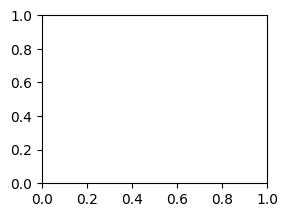

In [ ]:

#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[42][:,:,0])

plt.subplot(222)
plt.imshow(x_train[420][:,:,0])

plt.subplot(223)
plt.imshow(x_train[4200][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42000][:,:,0])
plt.show()



In [ ]:

# BUILD THE MODEL


# # Encoder


latent_dim = 2

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = x.shape #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)


z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately.
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])


# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())



In [ ]:
# Decoder


decoder_input = Input(shape=(latent_dim, ), name='decoder_input')


x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)

x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample
z_decoded = decoder(z)






In [ ]:
#Define custom loss

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = keras.layers.Flatten(x)
        z_decoded = keras.layers.Flatten(z_decoded)

        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomLayer()([input_img, z_decoded])

# =================


In [ ]:
# VAE

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()


In [ ]:
# Train autoencoder
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

In [ ]:
# Visualize results
# =================
#Visualize inputs mapped to the Latent space


mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()



In [ ]:

# Visualize images

sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)



n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))


In [ ]:
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()